In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. 

**Дополнительно:**  
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC  
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

Итак, приступаем. Задание № ***1. Провести анализ данных.***

In [3]:
data = pd.read_csv('kobe.csv')

In [4]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         30697 non-null  object 
 1   combined_shot_type  30697 non-null  object 
 2   game_event_id       30697 non-null  int64  
 3   game_id             30697 non-null  int64  
 4   lat                 30697 non-null  float64
 5   loc_x               30697 non-null  int64  
 6   loc_y               30697 non-null  int64  
 7   lon                 30697 non-null  float64
 8   minutes_remaining   30697 non-null  int64  
 9   period              30697 non-null  int64  
 10  playoffs            30697 non-null  int64  
 11  season              30697 non-null  object 
 12  seconds_remaining   30697 non-null  int64  
 13  shot_distance       30697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           30697 non-null  object 
 16  shot

С данными познакомились. Что можно сказать: пропусков в данных тнет, и это хорошо. Исключение составляет столбец "shot_made_flag", но он наш таргет, и поэтому 5000 пропусков как раз надо предсказать. Посмотрим поближе на таргет:

In [6]:
data['shot_made_flag'].unique()

array([nan,  0.,  1.])

In [7]:
data['shot_made_flag'].value_counts()

0.0    14232
1.0    11465
Name: shot_made_flag, dtype: int64

Итак, будем решать задачу классификации.  

Для начала удалим строки, где таргет пропущен, т.к. нет смысла додумывать значения целевой переменной:

In [8]:
data.isna().sum()

action_type              0
combined_shot_type       0
game_event_id            0
game_id                  0
lat                      0
loc_x                    0
loc_y                    0
lon                      0
minutes_remaining        0
period                   0
playoffs                 0
season                   0
seconds_remaining        0
shot_distance            0
shot_made_flag        5000
shot_type                0
shot_zone_area           0
shot_zone_basic          0
shot_zone_range          0
team_id                  0
team_name                0
game_date                0
matchup                  0
opponent                 0
shot_id                  0
dtype: int64

In [9]:
data = data.dropna()

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25697 entries, 1 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         25697 non-null  object 
 1   combined_shot_type  25697 non-null  object 
 2   game_event_id       25697 non-null  int64  
 3   game_id             25697 non-null  int64  
 4   lat                 25697 non-null  float64
 5   loc_x               25697 non-null  int64  
 6   loc_y               25697 non-null  int64  
 7   lon                 25697 non-null  float64
 8   minutes_remaining   25697 non-null  int64  
 9   period              25697 non-null  int64  
 10  playoffs            25697 non-null  int64  
 11  season              25697 non-null  object 
 12  seconds_remaining   25697 non-null  int64  
 13  shot_distance       25697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           25697 non-null  object 
 16  shot

Отлично! Теперь посмотрим на столбцы поближе: посмотрим на разброс данных в них, определим наличие выбросов и аномалий:

Графики распределения значений и боксплот для столбца game_event_id 


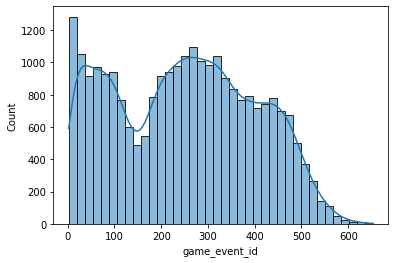

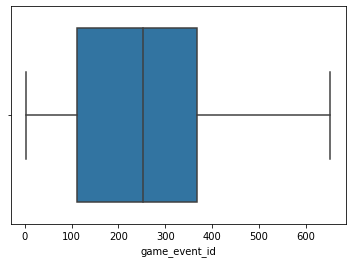

Графики распределения значений и боксплот для столбца game_id 


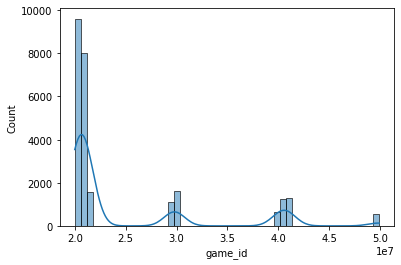

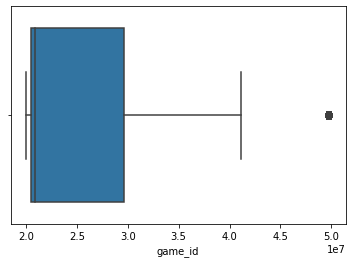

Графики распределения значений и боксплот для столбца lat 


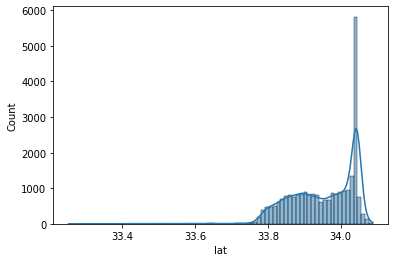

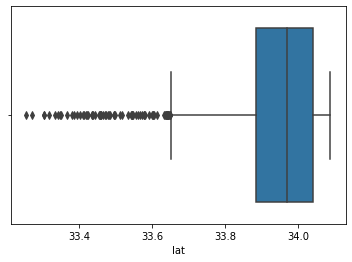

Графики распределения значений и боксплот для столбца loc_x 


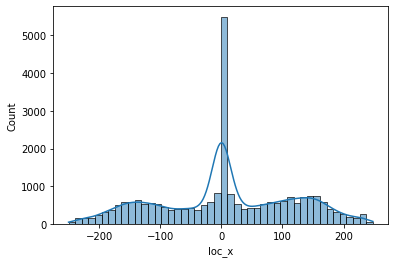

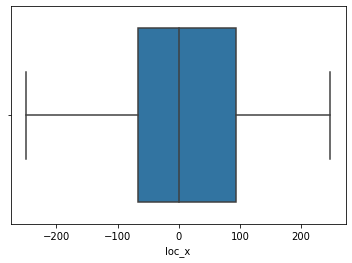

Графики распределения значений и боксплот для столбца loc_y 


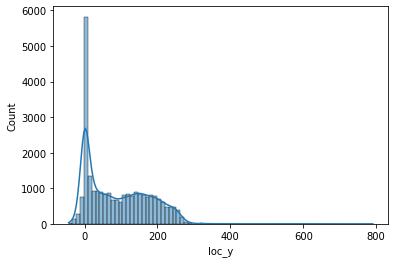

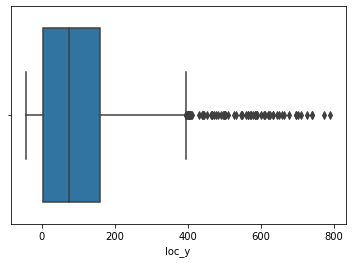

Графики распределения значений и боксплот для столбца lon 


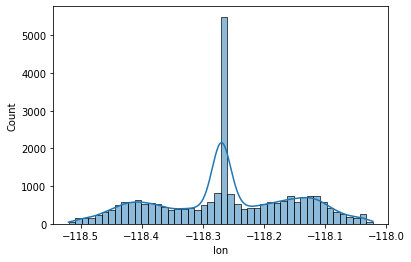

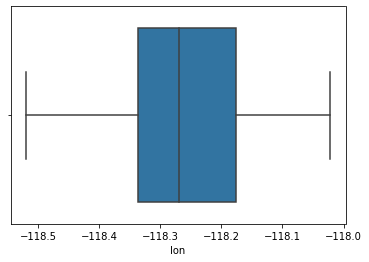

Графики распределения значений и боксплот для столбца minutes_remaining 


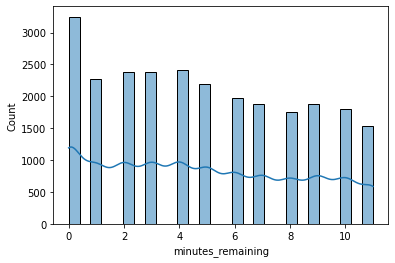

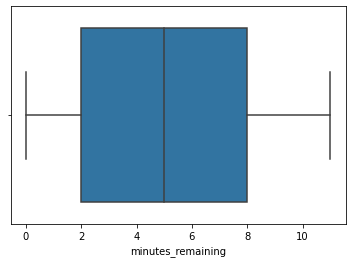

Графики распределения значений и боксплот для столбца period 


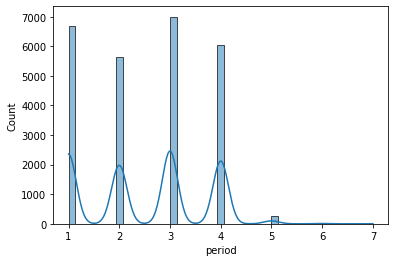

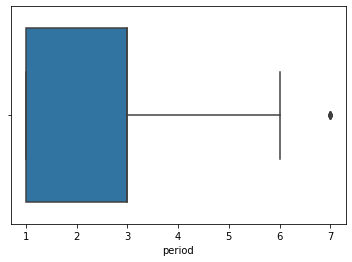

Графики распределения значений и боксплот для столбца playoffs 


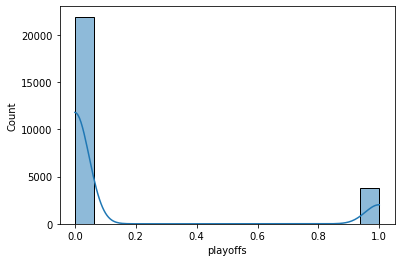

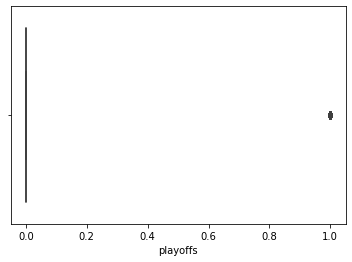

Графики распределения значений и боксплот для столбца seconds_remaining 


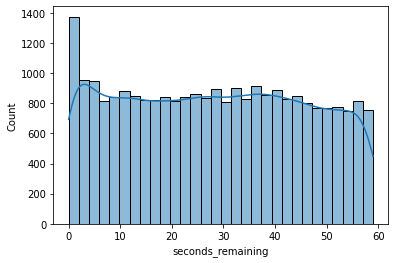

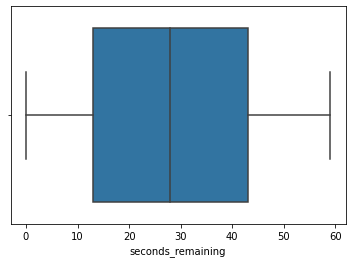

Графики распределения значений и боксплот для столбца shot_distance 


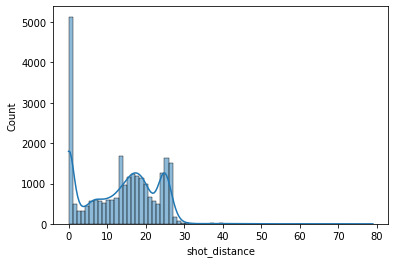

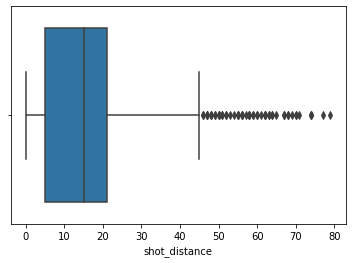

Графики распределения значений и боксплот для столбца shot_made_flag 


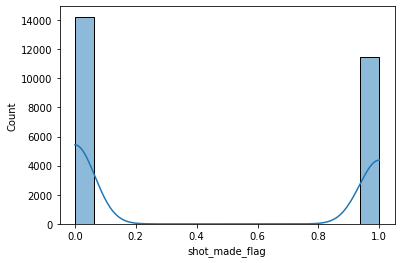

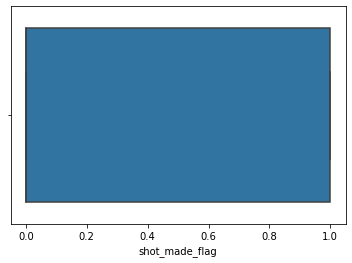

Графики распределения значений и боксплот для столбца team_id 


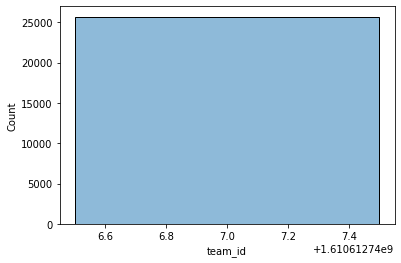

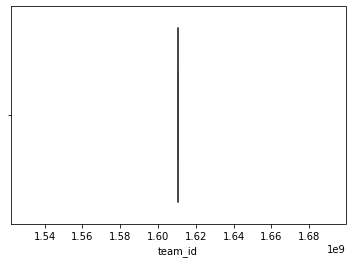

Графики распределения значений и боксплот для столбца shot_id 


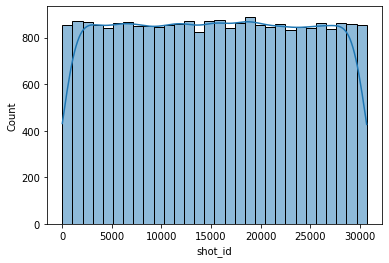

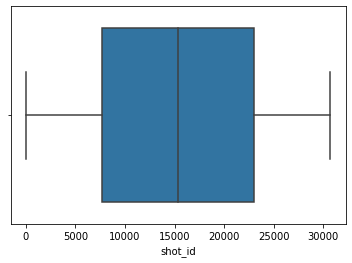

In [11]:
for column in data.columns:
    if data['{}'.format(column)].dtype == 'int64' or data['{}'.format(column)].dtype == 'float64':
        print('Графики распределения значений и боксплот для столбца', '\x1b[1;0346m'+'{} '.format(column) +'\x1b[0m')
        sns.histplot(data=data, x="{}".format(column), kde=True)
        plt.show()
        sns.boxplot(x=data['{}'.format(column)])
        plt.show()

Что можно сказать:  
  - У нас есть часть столбцов, где нет выбросов:  shot_id, team_id (совсем не видно боксплот - слишком маленький диапазон), shot_made_flag, seconds_remaining, playoffs (хотя там всего 2 значения: 0 и 1, нулей гораздо больше, поэтому единицы воспринимаются как выбросы), minutes_remaining, lon, loc_x, game_event_id.    
  -  Выбросы есть:  game_id, lat, loc_y, period, shot_distance. На них обратим внимание. Являются ли значения аномальными? Что будет, если мы их удалим?      
  -  Отдельно можно сказать про столбец loc_x: хотя у него и нет выбросов, но большая часть значений лежит у нуля. Из этой точки удобнее бить?

И еще у нас есть дисбаланс в целевой переменной:

In [12]:
data['shot_made_flag'].value_counts()

0.0    14232
1.0    11465
Name: shot_made_flag, dtype: int64

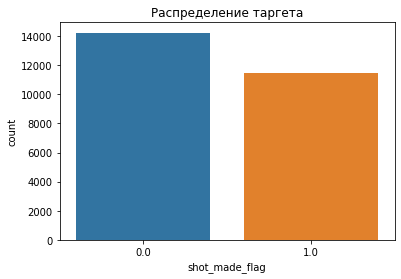

In [13]:
ax = plt.axes()
sns.countplot("shot_made_flag", data=data, ax=ax)
ax.set_title("Распределение таргета")
plt.show()

55% против 45%. Не сильно большой диссонанс, поэтому при разделении на выборки воспользуемся параметром stratify.

Посмотрим на статистические показатели:

In [14]:
desc_num = data.describe(include=['number'])
desc_num

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,25697.000000,2.569700e+04,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,2.569700e+04,25697.000000
mean,249.348679,2.474109e+07,33.953043,7.148422,91.257345,-118.262652,4.886796,2.520800,0.146243,28.311554,13.457096,0.446161,1.610613e+09,15328.166946
std,149.778520,7.738108e+06,0.088152,110.073147,88.152106,0.110073,3.452475,1.151626,0.353356,17.523392,9.388725,0.497103,0.000000e+00,8860.462397
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,2.000000
25%,111.000000,2.050006e+07,33.884300,-67.000000,4.000000,-118.336800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7646.000000
50%,253.000000,2.090034e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15336.000000
75%,367.000000,2.960027e+07,34.040300,94.000000,160.000000,-118.175800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,22976.000000
max,653.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000


Возникает еще вопрос: насколько нам нужны значения широты и долготы (lat и lon)? Также интересна необходимость столбцов с id.  
    Проанализируем категориальные признаки и вернемся к вопросу важности столбцов чуть позже:

А вот наши признаки типа "объект" посмотрим по распределению значений и по их влинию на целевую переменную:

Влияние значений столбца action_type  на таргет:


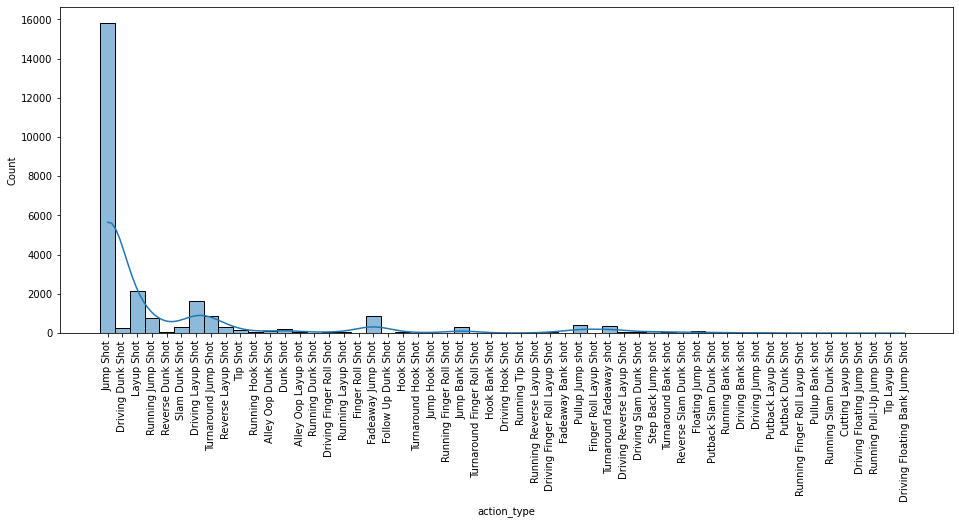

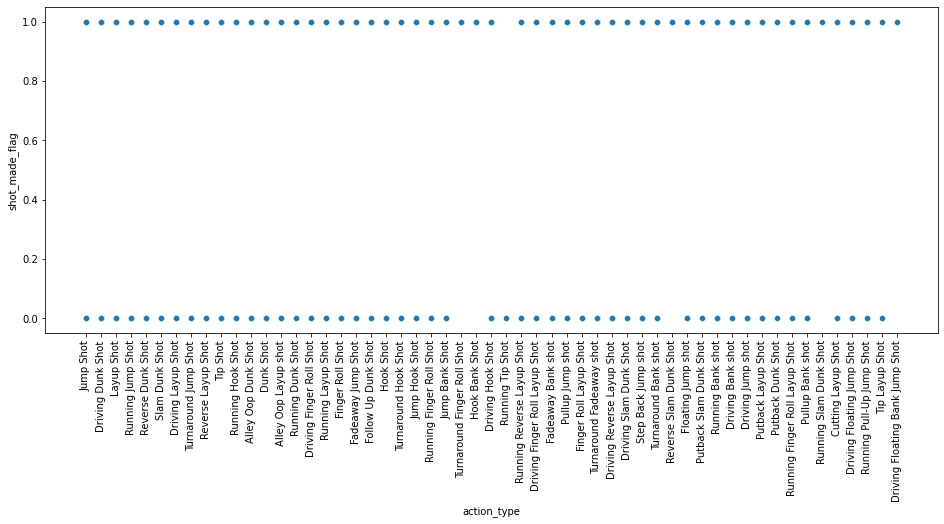

Влияние значений столбца combined_shot_type  на таргет:


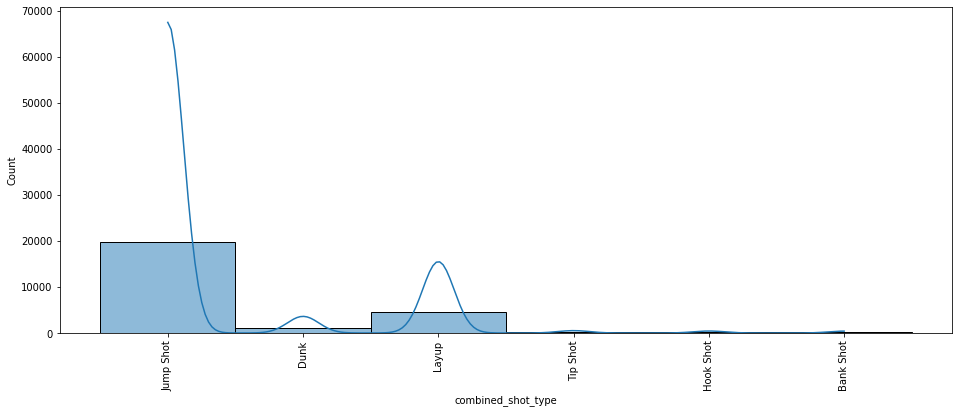

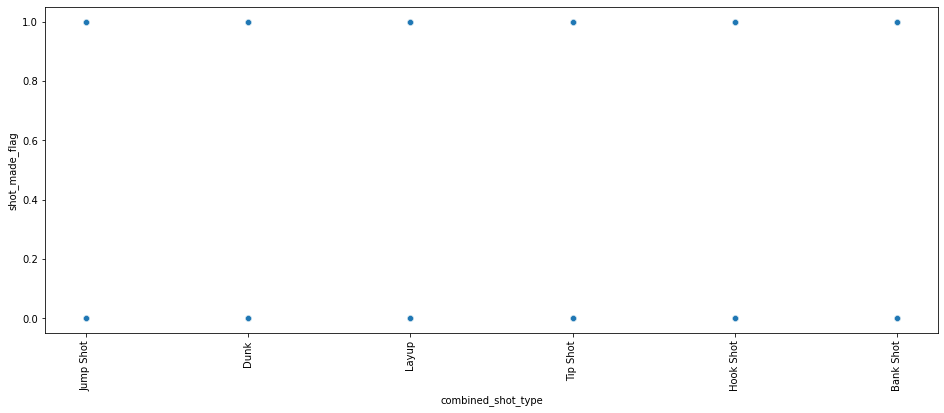

Влияние значений столбца season  на таргет:


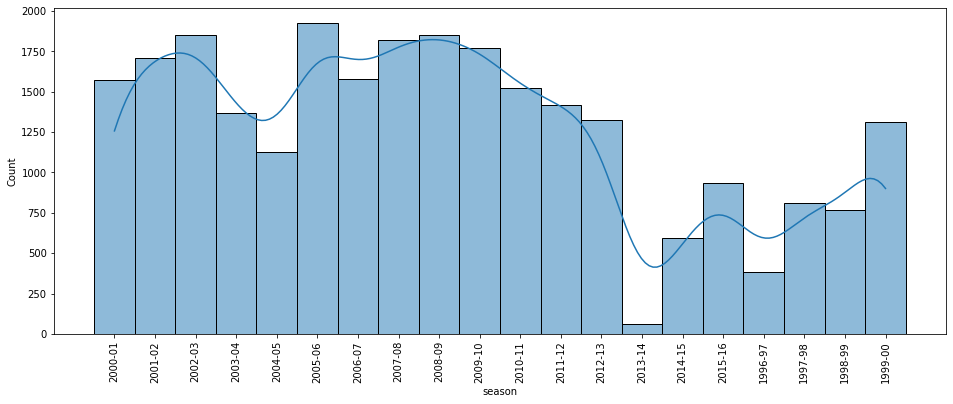

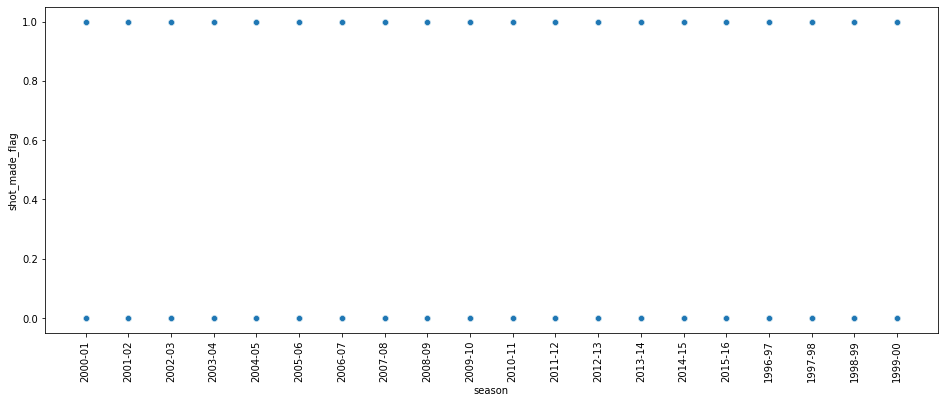

Влияние значений столбца shot_type  на таргет:


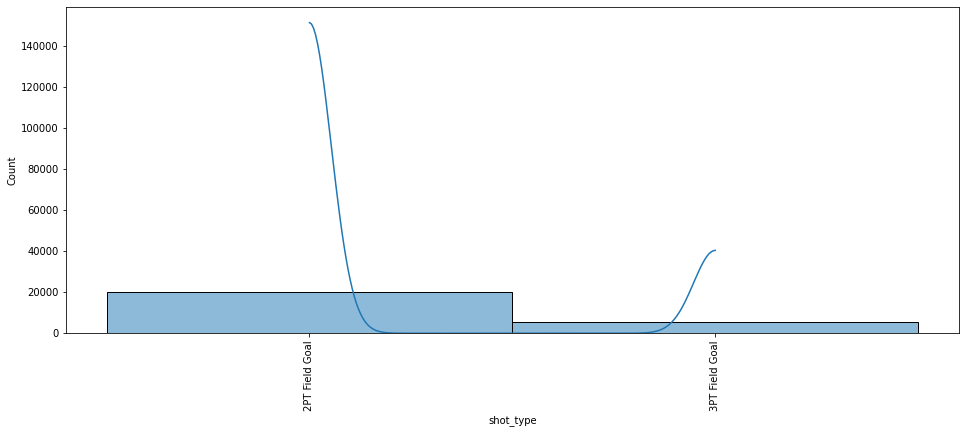

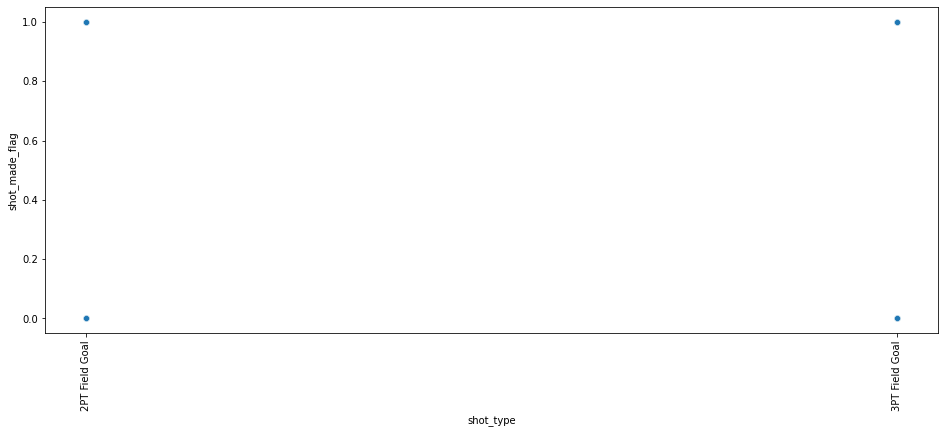

Влияние значений столбца shot_zone_area  на таргет:


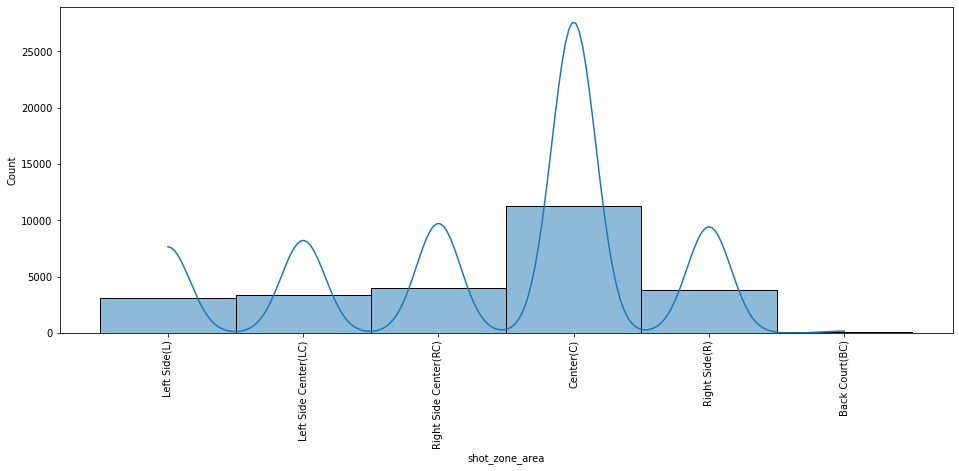

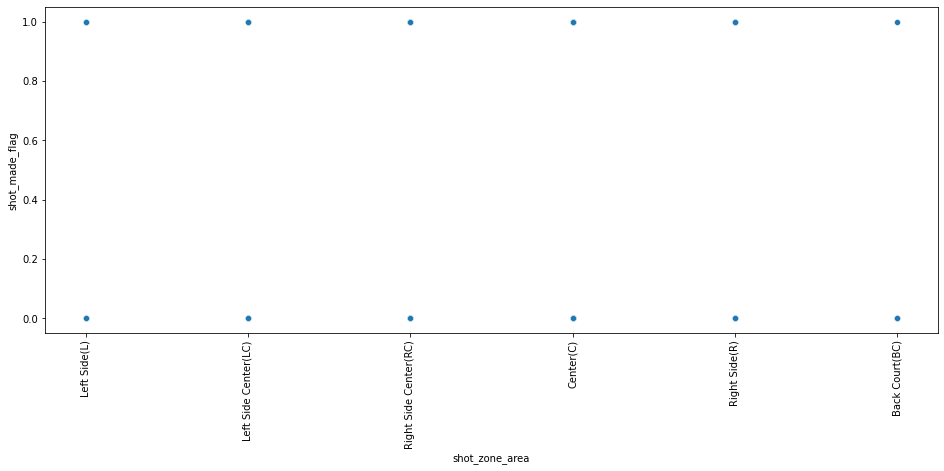

Влияние значений столбца shot_zone_basic  на таргет:


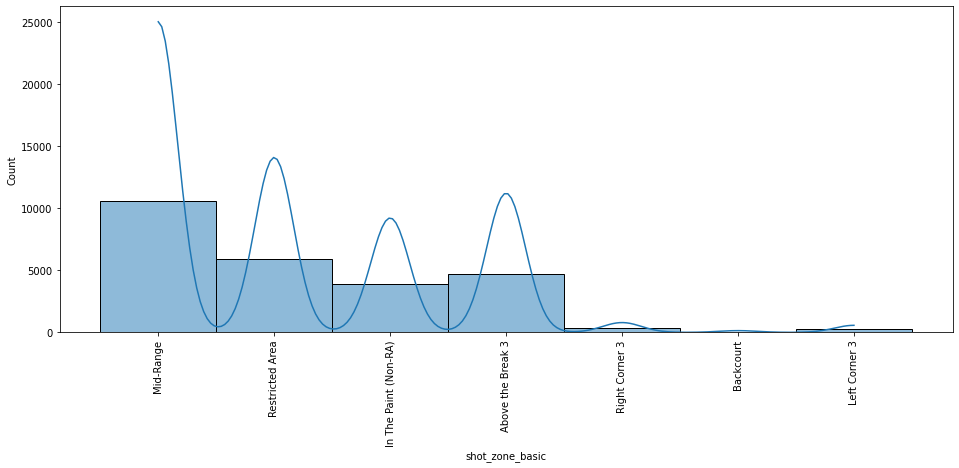

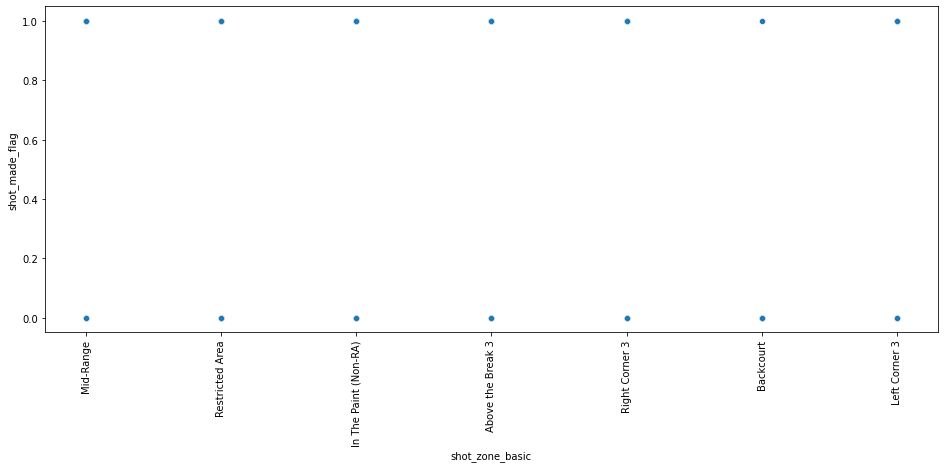

Влияние значений столбца shot_zone_range  на таргет:


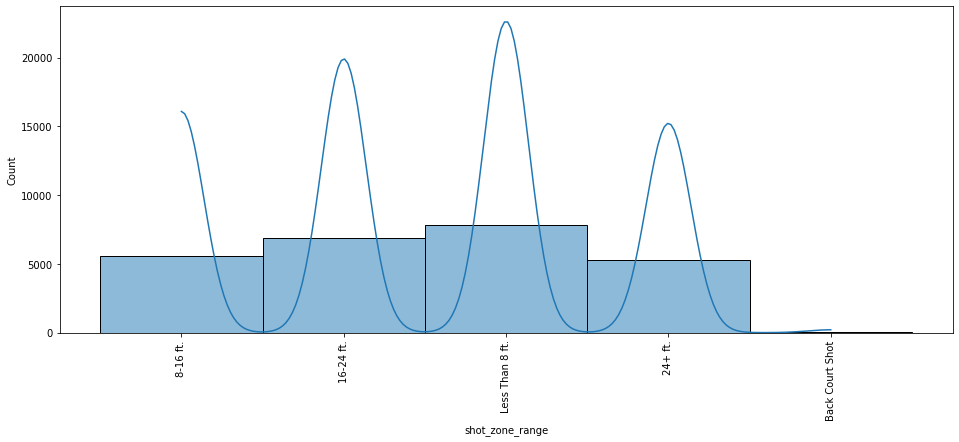

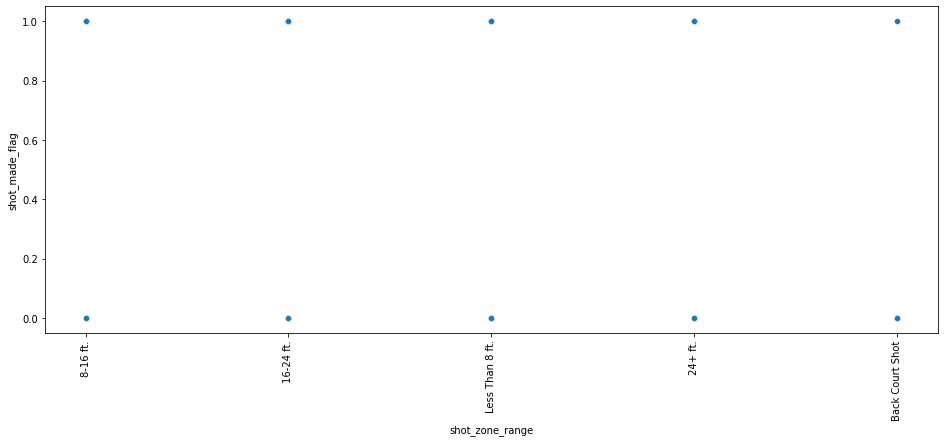

Влияние значений столбца team_name  на таргет:


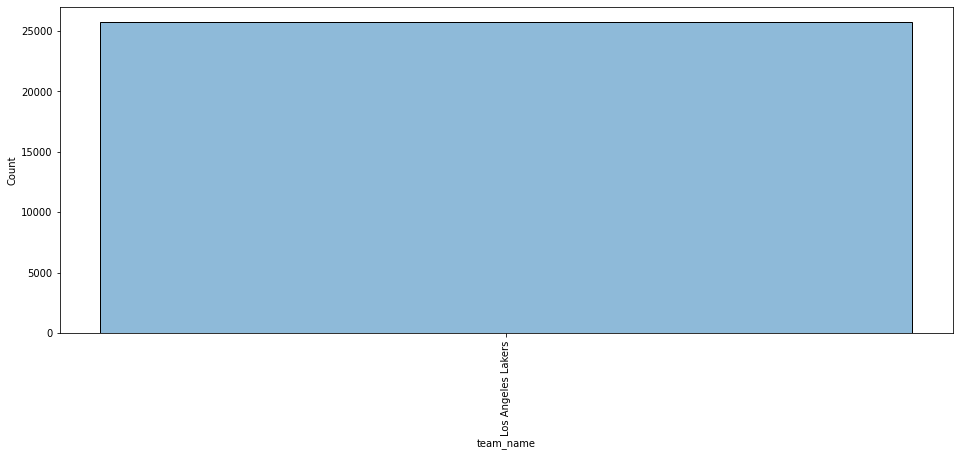

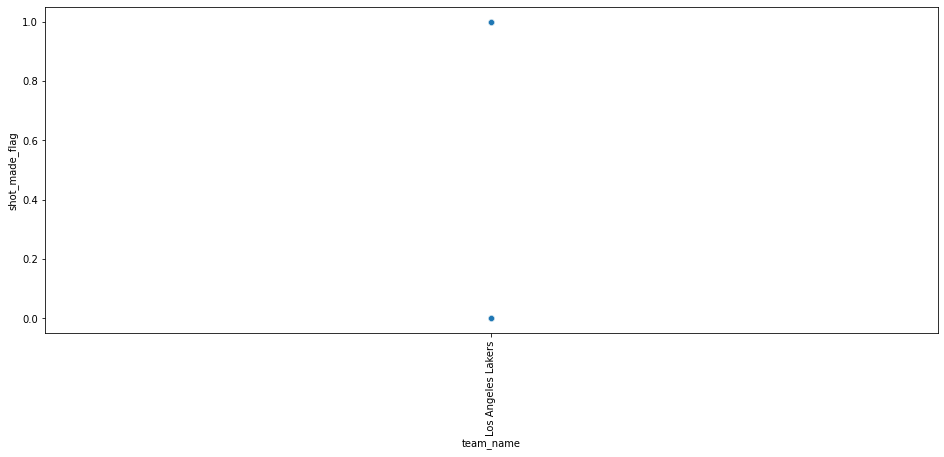

Влияние значений столбца game_date  на таргет:


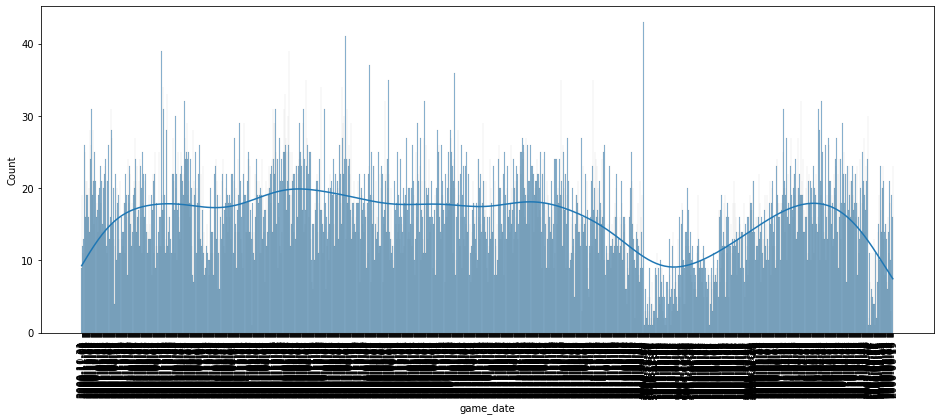

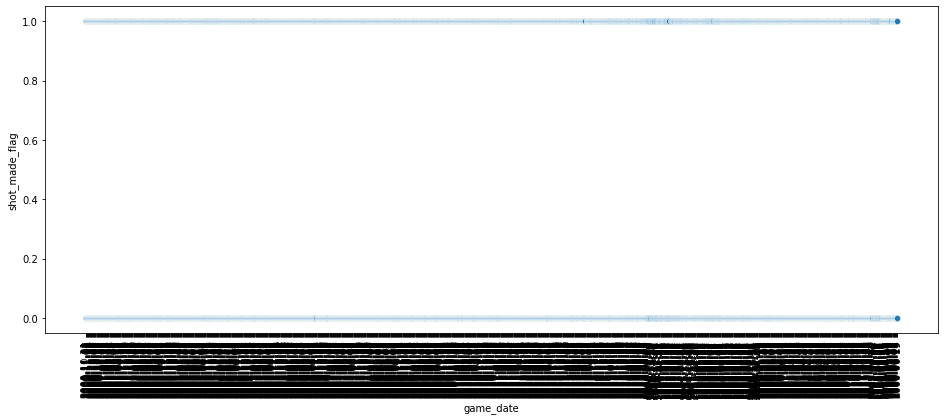

Влияние значений столбца matchup  на таргет:


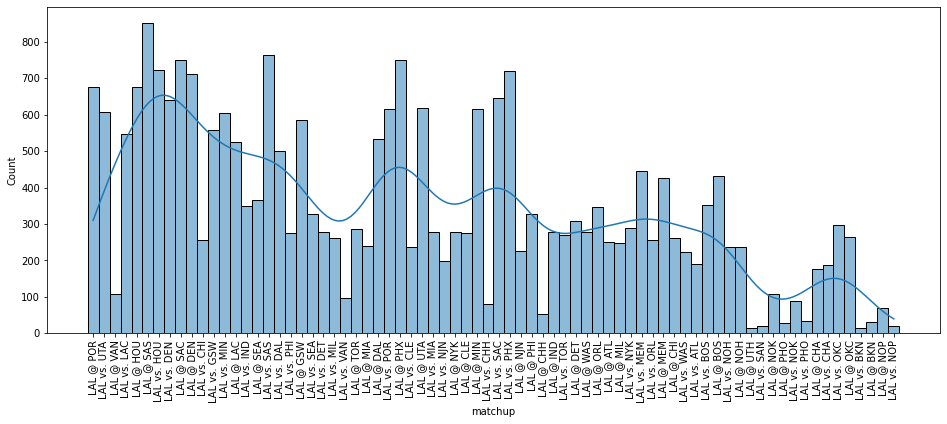

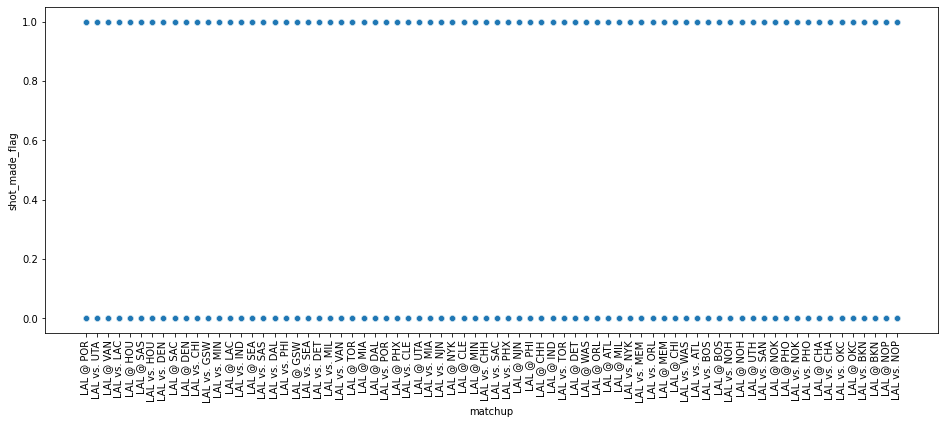

Влияние значений столбца opponent  на таргет:


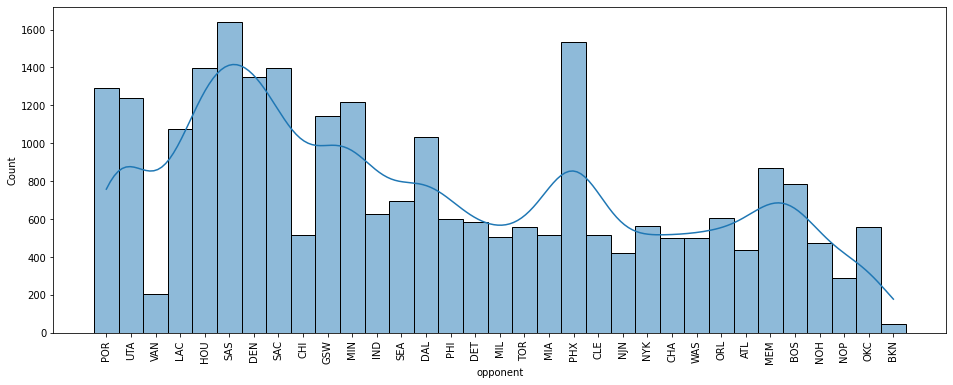

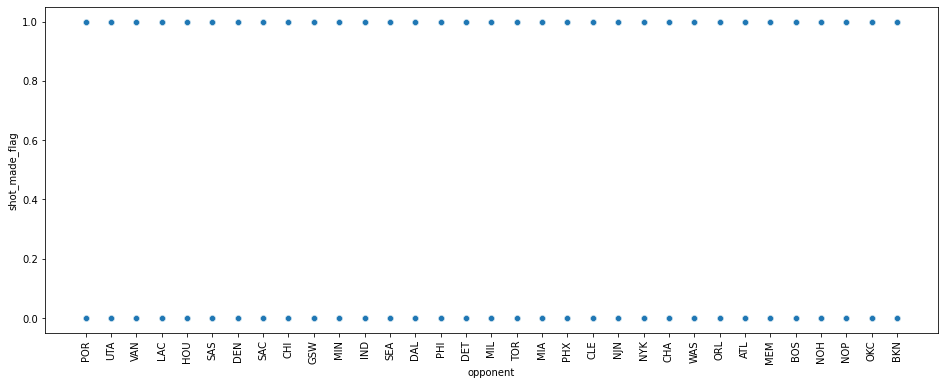

In [15]:
for column in data.columns:
    if data['{}'.format(column)].dtype == 'object':
        print('Влияние значений столбца', '\x1b[1;0346m'+'{} '.format(column) +'\x1b[0m', 'на таргет:')
        plt.figure(figsize=(16, 6))
        sns.histplot(data=data, x="{}".format(column), kde=True)
        plt.tick_params(axis='x', rotation=90)
        plt.show()
        plt.figure(figsize=(16, 6))
        sns.scatterplot(data=data, x='{}'.format(column), y="shot_made_flag")
        plt.tick_params(axis='x', rotation=90)
        plt.show()

Столбцов довольно много. Что можно заметить? 
- При примерно одинаковом количестве попаданий и пропусков (см. влияние столбцов на таргет) есть особенный столбец - action_type. Там видно, что были некоторые зависимости в исходе при принятии того или иного решения. Например, используя Running Tip Shot Кобе промахивался, в то врем как при Reverse Slam Dunk Shot - попадал в цель. Определенно данный признак в какой-то мере влияет на целевую переменную.  
- Еще бросается в глаза столбец team_name: там только одна команда. Это значит, что столбец нам не нужен - никакого влияния он не оказывает.  
- Что стоит посмотреть еще: столбцы со временем. Линейные модели неплохо работают с временными рядами. Посмотрим на гистограммы для столбцов поближе. Для этого применим тип данных "дата и время" к столбцам и построим гистограммы

In [16]:
data.describe(include=['object'])

,action_type,combined_shot_type,season,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_name,game_date,matchup,opponent
count,25697,25697,25697,25697,25697,25697,25697,25697,25697,25697,25697
unique,55,6,20,2,6,7,5,1,1558,74,33
top,Jump Shot,Jump Shot,2005-06,2PT Field Goal,Center(C),Mid-Range,Less Than 8 ft.,Los Angeles Lakers,2016-04-13,LAL @ SAS,SAS
freq,15836,19710,1924,20285,11289,10532,7857,25697,43,853,1638


Теперь видно, какое значение находится "в топе" в каждом столбце.  
Идем дальше:

Удаляем ненужный столбец:

In [17]:
data['team_name'].unique()

array(['Los Angeles Lakers'], dtype=object)

In [18]:
data = data.drop('team_name', axis=1)
data.shape

(25697, 24)

Теперь посмотрим зависимость попадания в кольцо от положения Кобе на поле:

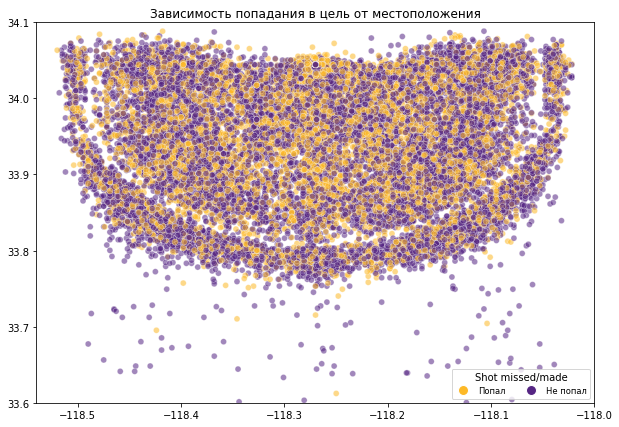

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
scatter = sns.scatterplot(x=data["lon"], y=data["lat"], hue=data['shot_made_flag'],
                                    alpha=0.55, ax=ax, palette=("#552583", "#FDB927"))
scatter.set_xlim(left=-118.54, right=-118)
scatter.set_ylim(bottom=33.6, top=34.1)
ax.set_title("Зависимость попадания в цель от местоположения")
ax.set_xlabel("")
ax.set_ylabel("")
legend_elemnts = [Line2D([0], [0], marker="o", color='w', label="Попал",
                         markerfacecolor="#FDB927", markersize=10),
                  Line2D([0], [0], marker="o", color='w', label="Не попал",
                         markerfacecolor="#552583", markersize=10)]
plt.legend(handles=legend_elemnts, title="Shot missed/made", 
           ncol=2, fontsize='small', fancybox=True);

Теперь видно, что из центра гораздо больше попаданий, чем с края поля. Также видна четкая линия, после которой попаданий становится резко меньше, а пропусков больше. В самом низу диаграммы рассеяния зона с самой высокой дисперсией и практически нулевым попаданием. Это логично: от кольца далеко, сама вероятность попадания стремится к нулю.

Переходим ко столбцу с датой:

In [20]:
data['game_date'] = pd.to_datetime(data['game_date'])
# Теперь нагенерим несколько признаков: вытащим из даты год, месяц, день недели и день года
data['year'] = pd.DatetimeIndex(data['game_date']).year
data['month'] = pd.DatetimeIndex(data['game_date']).month
data['dayOfWeek']    = data['game_date'].dt.dayofweek
data['dayOfYear']    = data['game_date'].dt.dayofyear
data = data.drop('game_date', axis=1)   # больше не нужен

data[['year', 'month', 'dayOfWeek', 'dayOfYear']].head()

,year,month,dayOfWeek,dayOfYear
1,2000,10,1,305
2,2000,10,1,305
3,2000,10,1,305
4,2000,10,1,305
5,2000,10,1,305


Строим графики:

Распределение значений в столбце year 


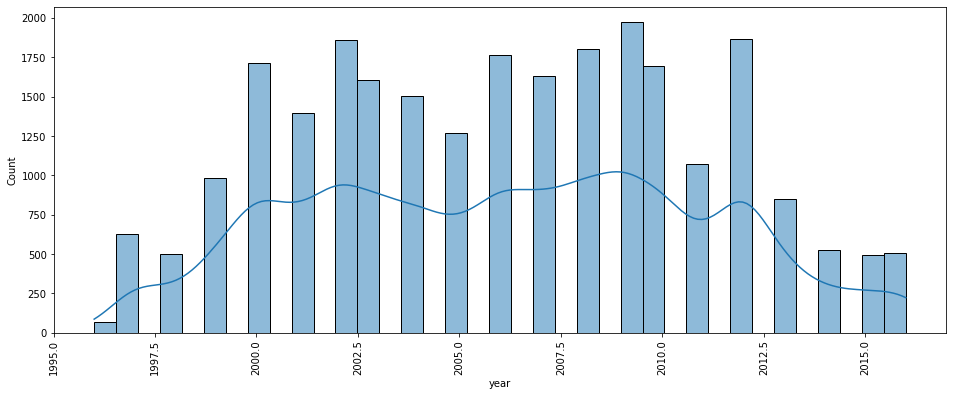

Распределение значений в столбце month 


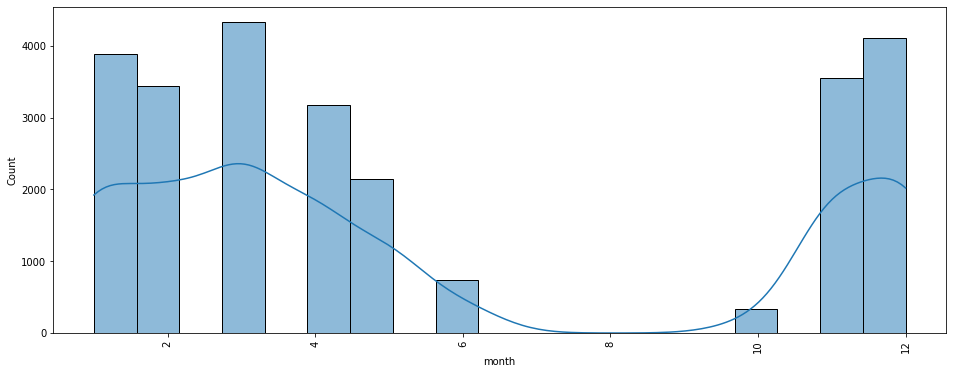

Распределение значений в столбце dayOfWeek 


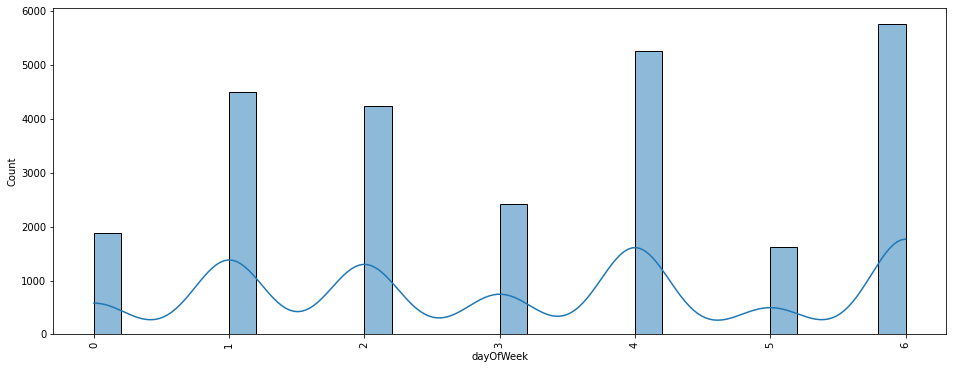

Распределение значений в столбце dayOfYear 


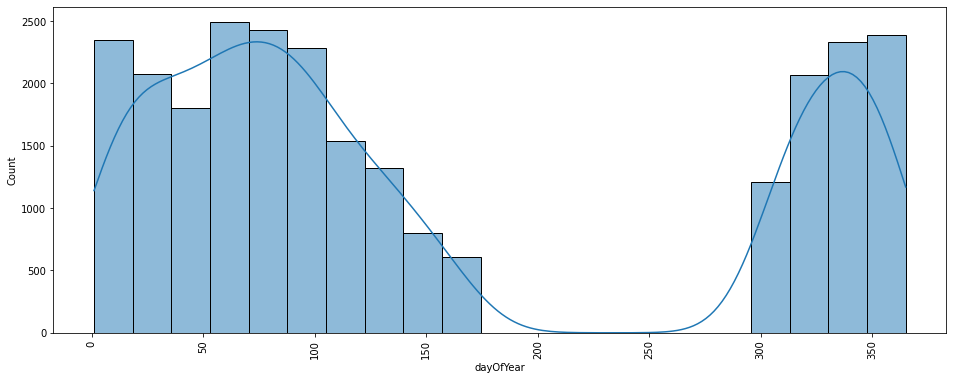

In [21]:
for d in data[['year', 'month', 'dayOfWeek', 'dayOfYear']]:
    print('Распределение значений в столбце', '\x1b[1;0346m'+'{} '.format(d) +'\x1b[0m')
    plt.figure(figsize=(16, 6))
    sns.histplot(data=data, x="{}".format(d), kde=True)
    plt.tick_params(axis='x', rotation=90)
    plt.show()

А вот и закономерности. Чаще всего Кобе играл по воскресеньям, пятницам и вторникам; летом и в начале осени был отпуск (или перерыв), а во второй половине осени и зимой были матчи. Если посмотреть на месяцы, то наши выводы подтверждаются наглядно.  Если обратим внимание на годы игр, то увидим, что самые активные периоды - 2000 - 2012. Пик карьеры.

Итак, мы нагенерировали несколько признаков. Теперь переведем категориальные признаки в формат, удобрый для обучения моделей и проверим, какие признаки "выстрелят":

In [22]:
data = pd.get_dummies(data, drop_first=True)
data.head()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,...,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS
1,12,20000012,34.0443,-157,0,-118.4268,10,1,0,22,...,0,0,1,0,0,0,0,0,0,0
2,35,20000012,33.9093,-101,135,-118.3708,7,1,0,45,...,0,0,1,0,0,0,0,0,0,0
3,43,20000012,33.8693,138,175,-118.1318,6,1,0,52,...,0,0,1,0,0,0,0,0,0,0
4,155,20000012,34.0443,0,0,-118.2698,6,2,0,19,...,0,0,1,0,0,0,0,0,0,0
5,244,20000012,34.0553,-145,-11,-118.4148,9,3,0,32,...,0,0,1,0,0,0,0,0,0,0


И поскольку тип данных в новых столбцах "uint8", изменим его на целые числа:

In [23]:
col_to_int = []
for col in data.columns:
    if data[col].dtype == 'uint8':
        col_to_int.append(col)

In [24]:
for i in col_to_int:
    data[i] = data[i].astype('int64')

Идём дальше:  
***2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.***

Теперь отделим таргет от фичей:

In [25]:
features = data.drop('shot_made_flag', axis=1)
target = data['shot_made_flag']
features.shape, target.shape

((25697, 216), (25697,))

In [26]:
target.isna().sum()

0

Разделим выборку на 3 части:

In [27]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=12345, stratify=target)

In [28]:
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=12345, stratify=target_valid)

In [29]:
features_train.shape, features_valid.shape, features_test.shape, target_train.shape, target_valid.shape, target_test.shape

((15418, 216), (5139, 216), (5140, 216), (15418,), (5139,), (5140,))

In [30]:
num = desc_num.columns.to_numpy().tolist()
num.remove('shot_made_flag')
num

['game_event_id',
 'game_id',
 'lat',
 'loc_x',
 'loc_y',
 'lon',
 'minutes_remaining',
 'period',
 'playoffs',
 'seconds_remaining',
 'shot_distance',
 'team_id',
 'shot_id']

In [31]:
scaler = StandardScaler()
scaler.fit(features_train[num])
features_train[num] = scaler.transform(features_train[num])
features_valid[num] = scaler.transform(features_valid[num])
features_test[num] = scaler.transform(features_test[num])
features_test.head()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,...,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS
17869,-0.460146,-0.484365,-0.718039,-0.049935,0.718039,-0.049935,0.040598,-0.448868,-0.415512,-0.595286,...,0,0,0,0,0,0,0,0,0,0
28660,1.739626,2.072457,1.036993,-0.068042,-1.036993,-0.068042,-0.250129,1.279348,2.406672,-0.709185,...,0,0,0,0,0,0,0,0,0,0
1753,0.033136,-0.600704,1.104495,1.271898,-1.104495,1.271898,1.203503,0.415240,-0.415512,-0.766135,...,0,0,0,0,0,0,0,0,0,0
11135,-1.180072,-0.536025,-0.290531,1.117986,0.290531,1.117986,-0.250129,-1.312976,-0.415512,1.625749,...,0,0,0,0,0,0,0,0,0,0
30008,-0.033524,2.111200,1.036993,-0.031828,-1.036993,-0.031828,-0.540855,-0.448868,2.406672,0.429807,...,0,0,0,0,0,0,0,0,0,0


Пробуем обучить как есть логистическую регрессию:

In [32]:
log_reg = LogisticRegression(random_state=12345).fit(features_train, target_train)

In [33]:
predict_proba = log_reg.predict_proba(features_valid)
print(classification_report(target_valid, log_reg.predict(features_valid), target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.67      0.83      0.74      2846
     class 1       0.70      0.49      0.58      2293

    accuracy                           0.68      5139
   macro avg       0.68      0.66      0.66      5139
weighted avg       0.68      0.68      0.67      5139



Результат пока не очень радует. Посмотрим, какие признаки "выстрелили" лучше всего:

Feature: game_event_id, Score: -0.01033
Feature: game_id, Score: 0.01260
Feature: lat, Score: -0.05358
Feature: loc_x, Score: 0.01880
Feature: loc_y, Score: 0.05358
Feature: lon, Score: 0.01880
Feature: minutes_remaining, Score: 0.05276
Feature: period, Score: -0.04465
Feature: playoffs, Score: 0.02151
Feature: seconds_remaining, Score: 0.05133
Feature: shot_distance, Score: -0.12021
Feature: team_id, Score: 0.00000
Feature: shot_id, Score: -0.07996
Feature: year, Score: 0.00045
Feature: month, Score: -0.02840
Feature: dayOfWeek, Score: -0.00247
Feature: dayOfYear, Score: 0.00096
Feature: action_type_Alley Oop Layup shot, Score: 0.01017
Feature: action_type_Cutting Layup Shot, Score: -0.00011
Feature: action_type_Driving Bank shot, Score: 0.00075
Feature: action_type_Driving Dunk Shot, Score: 0.18179
Feature: action_type_Driving Finger Roll Layup Shot, Score: 0.03098
Feature: action_type_Driving Finger Roll Shot, Score: 0.03339
Feature: action_type_Driving Floating Bank Jump Shot, Scor

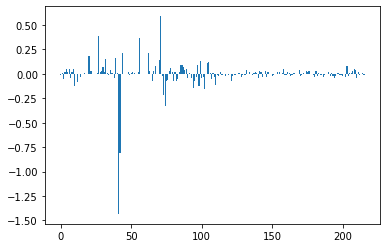

In [34]:
importance = log_reg.coef_[0]

features_important = pd.DataFrame()
feat = []
score = []

for i,v in enumerate(importance):
    feat.append(features_train.columns[i])
    score.append(v)
    print('Feature: %0s, Score: %.5f' % (features_train.columns[i],v))

features_important['feature'] = feat
features_important['score'] = score
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [35]:
features_important.sort_values('score').head(10)

,feature,score
41,action_type_Jump Shot,-1.433601
42,action_type_Layup Shot,-0.811707
74,combined_shot_type_Layup,-0.332368
73,combined_shot_type_Jump Shot,-0.220841
102,shot_zone_basic_In The Paint (Non-RA),-0.149989
94,season_2015-16,-0.141609
10,shot_distance,-0.120207
98,shot_zone_area_Left Side(L),-0.119780
110,shot_zone_range_Less Than 8 ft.,-0.113169
12,shot_id,-0.079965


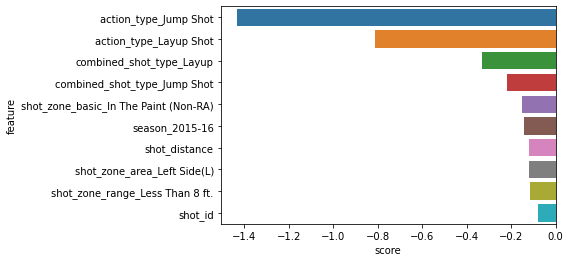

In [36]:
sns.barplot(x="score", y="feature", data=features_important.sort_values('score').head(10))
plt.show()

In [37]:
features_important.sort_values('score').tail(10)

,feature,score
99,shot_zone_area_Right Side Center(RC),0.137045
70,action_type_Turnaround Jump Shot,0.142295
32,action_type_Fadeaway Jump Shot,0.153552
39,action_type_Jump Bank Shot,0.159538
20,action_type_Driving Dunk Shot,0.181787
44,action_type_Pullup Jump shot,0.210399
62,action_type_Slam Dunk Shot,0.210795
56,action_type_Running Jump Shot,0.362337
27,action_type_Driving Layup Shot,0.389767
71,combined_shot_type_Dunk,0.590159


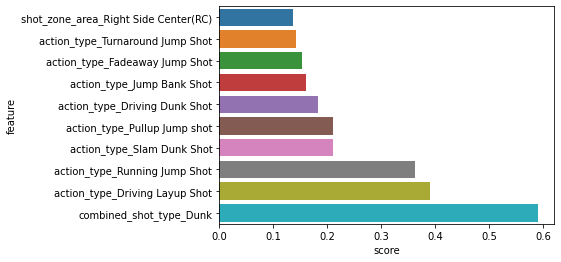

In [38]:
sns.barplot(x="score", y="feature", data=features_important.sort_values('score').tail(10))
plt.show()

Вот наиболее значимые для модель признаки. Еще раз посмотрим на них:

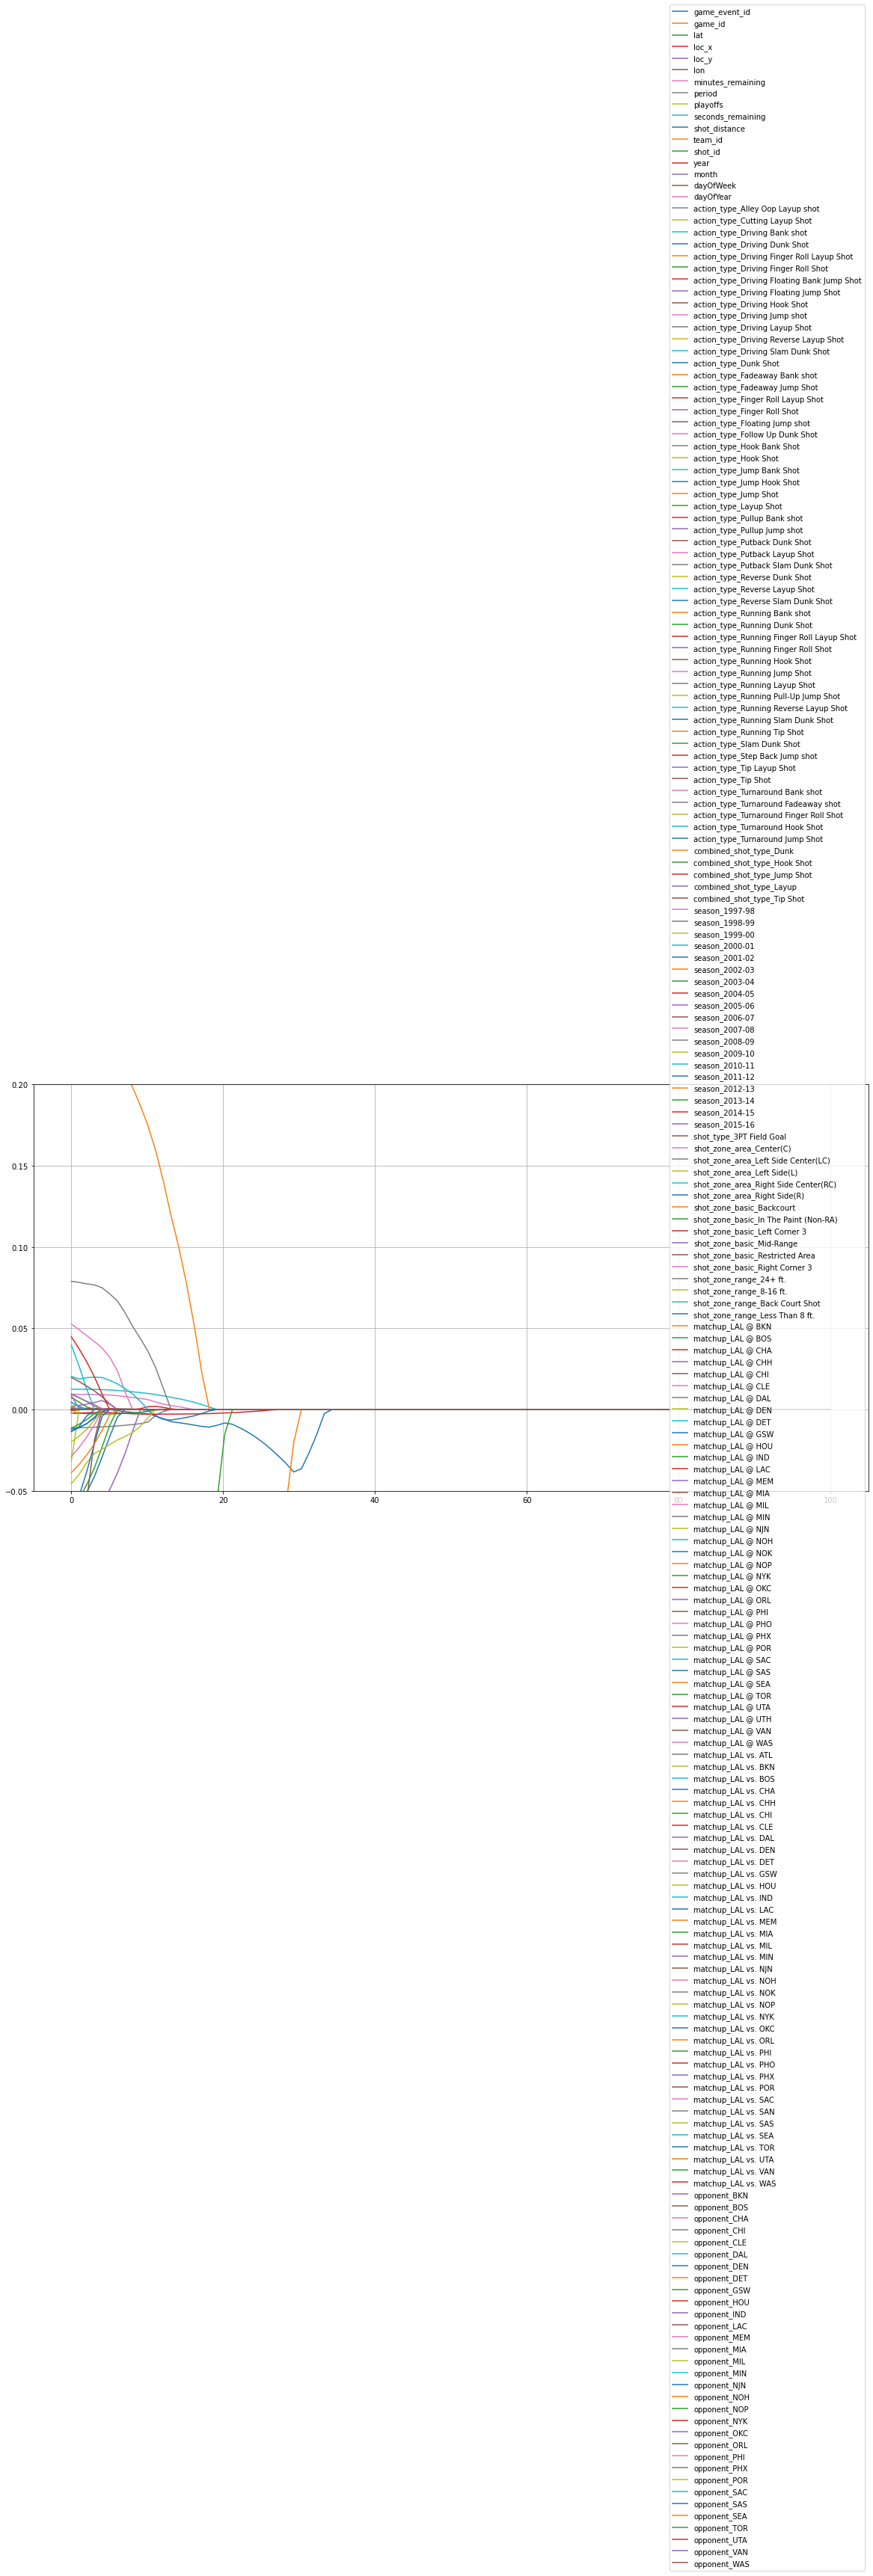

In [39]:
lg_l,pred_l = [], []

list_l=list(2**np.linspace(-10,10,100))

for i in range(len(list_l)):
    m_l = Lasso(alpha=list_l[i]).fit(features_train, target_train)
    lg_l.append(m_l)
    pred_l.append(m_l.coef_)

plt.figure(figsize=(20, 10))
x_l = np.linspace(0,len(pred_l),len(pred_l))
for i in np.vstack(pred_l).T:
    plt.plot(x_l,np.sign(i)*np.abs(i)) 
plt.ylim(-0.05,0.2)  
plt.legend(features_train.columns, loc='center right')  
plt.grid() 

Ничего не понятно. Попробуем посмотреть всё, что не зануляется:

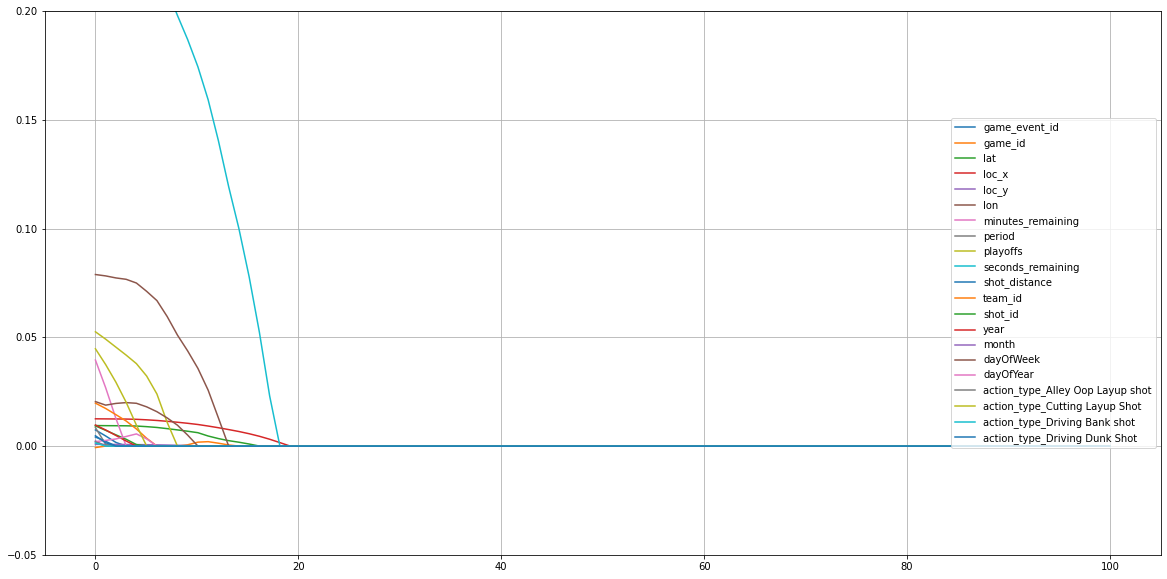

In [40]:
lg_l,pred_l = [], []

list_l=list(2**np.linspace(-10,10,100))

for i in range(len(list_l)):
    m_l = Lasso(alpha=list_l[i]).fit(features_train, target_train)
    lg_l.append(m_l)
    pred_l.append(m_l.coef_)

plt.figure(figsize=(20, 10))
x_l = np.linspace(0,len(pred_l),len(pred_l))
for i in np.vstack(pred_l).T:
    val = np.sign(i)*np.abs(i)
    if val.mean() > 0:
        plt.plot(x_l, val)
plt.ylim(-0.05,0.2)  
plt.legend(features_train.columns, loc='center right')  
plt.grid() 

Получившиеся столбцы перекликаются с теми, что мы вывели по результатам работы модели. Возьмем их все за основу:

In [41]:
features_important.sort_values('score')['feature'].head(10).tolist()

['action_type_Jump Shot',
 'action_type_Layup Shot',
 'combined_shot_type_Layup',
 'combined_shot_type_Jump Shot',
 'shot_zone_basic_In The Paint (Non-RA)',
 'season_2015-16',
 'shot_distance',
 'shot_zone_area_Left Side(L)',
 'shot_zone_range_Less Than 8 ft.',
 'shot_id']

In [42]:
new_columns = ['game_event_id', 'game_id', 'lat', 'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs', 
               'seconds_remaining', 'shot_distance', 'team_id', 'shot_id', 'year', 'month', 'dayOfWeek', 'dayOfYear',
              'action_type_Alley Oop Layup shot', 'action_type_Cutting Layup Shot', 'action_type_Driving Bank shot',
              'action_type_Driving Dunk Shot', 'shot_zone_area_Right Side Center(RC)', 'action_type_Turnaround Jump Shot',
              'action_type_Fadeaway Jump Shot', 'action_type_Jump Bank Shot', 'action_type_Pullup Jump shot', 
               'action_type_Slam Dunk Shot', 'action_type_Running Jump Shot', 'action_type_Driving Layup Shot', 
               'combined_shot_type_Dunk', 'action_type_Jump Shot', 'action_type_Layup Shot', 'combined_shot_type_Layup', 
               'combined_shot_type_Jump Shot', 'shot_zone_basic_In The Paint (Non-RA)', 'season_2015-16', 'shot_distance', 
               'shot_zone_area_Left Side(L)', 'shot_zone_range_Less Than 8 ft.', 'shot_id']

Теперь снова формируем фичи:

In [43]:
new_features_train = features_train[new_columns]
new_features_valid = features_valid[new_columns]
new_features_test = features_test[new_columns]

Отлично. Теперь снова обучим модель и посмотрим, какие признаки покажут себя лучше всех:

In [44]:
log_reg = LogisticRegression(random_state=12345).fit(new_features_train, target_train)
# print('ROC-AUC Score for new LogisticRegression: {}'.format(roc_auc_score(target_valid, log_reg.predict_proba(new_features_valid)[:, 1])))
print(classification_report(target_valid, log_reg.predict(new_features_valid), target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.67      0.82      0.74      2846
     class 1       0.69      0.50      0.58      2293

    accuracy                           0.68      5139
   macro avg       0.68      0.66      0.66      5139
weighted avg       0.68      0.68      0.67      5139



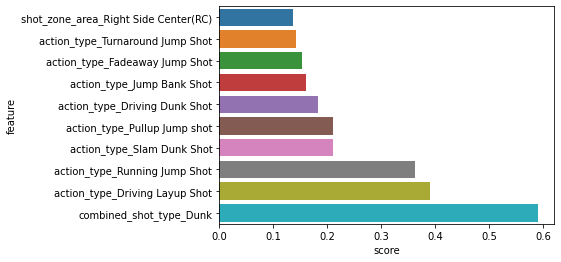

In [45]:
sns.barplot(x="score", y="feature", data=features_important.sort_values('score').tail(10))
plt.show()

Результат получился несколько хуже, чем раньше. Попробуем оставить только первые 10 по важности фичей. И из них сгенерируем признаки при помощи полинома:

In [46]:
poly = PolynomialFeatures(2)

In [47]:
f_train_poly = poly.fit_transform(new_features_train[(features_important.sort_values('score')['feature'].tail(10).tolist()) and (features_important.sort_values('score')['feature'].head(10).tolist())])
f_valid_poly = poly.fit_transform(new_features_valid[(features_important.sort_values('score')['feature'].tail(10).tolist()) and (features_important.sort_values('score')['feature'].head(10).tolist())])
f_test_poly = poly.fit_transform(new_features_test[(features_important.sort_values('score')['feature'].tail(10).tolist()) and (features_important.sort_values('score')['feature'].head(10).tolist())])
poly.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x6',
 'x7',
 'x8',
 'x9',
 'x10',
 'x11',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x0 x5',
 'x0 x6',
 'x0 x7',
 'x0 x8',
 'x0 x9',
 'x0 x10',
 'x0 x11',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x1 x5',
 'x1 x6',
 'x1 x7',
 'x1 x8',
 'x1 x9',
 'x1 x10',
 'x1 x11',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x2 x5',
 'x2 x6',
 'x2 x7',
 'x2 x8',
 'x2 x9',
 'x2 x10',
 'x2 x11',
 'x3^2',
 'x3 x4',
 'x3 x5',
 'x3 x6',
 'x3 x7',
 'x3 x8',
 'x3 x9',
 'x3 x10',
 'x3 x11',
 'x4^2',
 'x4 x5',
 'x4 x6',
 'x4 x7',
 'x4 x8',
 'x4 x9',
 'x4 x10',
 'x4 x11',
 'x5^2',
 'x5 x6',
 'x5 x7',
 'x5 x8',
 'x5 x9',
 'x5 x10',
 'x5 x11',
 'x6^2',
 'x6 x7',
 'x6 x8',
 'x6 x9',
 'x6 x10',
 'x6 x11',
 'x7^2',
 'x7 x8',
 'x7 x9',
 'x7 x10',
 'x7 x11',
 'x8^2',
 'x8 x9',
 'x8 x10',
 'x8 x11',
 'x9^2',
 'x9 x10',
 'x9 x11',
 'x10^2',
 'x10 x11',
 'x11^2']

In [48]:
f_train_poly.shape, f_valid_poly.shape, f_test_poly.shape

((15418, 91), (5139, 91), (5140, 91))

Плавно переходим к следующему пункту:  
***3. Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются.***

In [49]:
log_reg_poly = LogisticRegression().fit(f_train_poly, target_train)
weights_log_reg_poly = log_reg_poly.coef_
print('Weights: {}'.format(log_reg_poly.coef_))
print('Bias: {}'.format(log_reg_poly.intercept_))

print('\n', 'Classification_report')
print(classification_report(target_valid, log_reg_poly.predict(f_valid_poly).round(), target_names=['class 0', 'class 1']))

Weights: [[ 0.10571608 -0.47194747 -0.28597123 -0.34160942  0.21474364 -0.06303886
  -0.14558429 -0.25510607 -0.25510607  0.13609936 -0.23367121  0.01311802
   0.01311802 -0.47194747  0.          0.         -0.47194747 -0.05051165
   0.1384007   0.17261374  0.17261374 -0.09381292 -0.21087982  0.10151665
   0.10151665 -0.28597123 -0.28597123  0.          0.23935432  0.13458969
   0.19330314  0.19330314 -0.07107083 -0.0277516   0.09579352  0.09579352
  -0.34160942  0.          0.02841522  0.37200288 -0.0149072  -0.0149072
  -0.07107083 -0.10851336 -0.01384956 -0.01384956  0.21474364  0.48959959
  -0.02558275  0.44722909  0.44722909 -0.37702877 -0.02930509 -0.10805415
  -0.10805415 -0.06303886 -0.38208313 -0.16113182 -0.16113182 -0.22212486
  -0.60108689  0.03330875  0.03330875 -0.14558429 -0.04901419 -0.04901419
   0.36586625  0.03164111 -0.18525962 -0.18525962 -0.18272316 -0.18272316
  -0.02861238 -0.84118671 -0.00900472 -0.00900472 -0.18272316 -0.02861238
  -0.84118671 -0.00900472 -0.0

На данный момент самый высокий результат. Видно, что модель стала немного лучше выявлять 1 класс. Что можно сделать еще?
Попробуем построить модели с регуляризацией L1 и L2. Начнем с модели Lasso:

In [50]:
lasso_poly = Lasso(alpha=0.001).fit(f_train_poly, target_train)
weights_lasso = lasso_poly.coef_
print('Weights: {}'.format(lasso_poly.coef_))
print('Bias: {}'.format(lasso_poly.intercept_))

print('\n', 'Classification_report')
print(classification_report(target_valid, lasso_poly.predict(f_valid_poly).round(), target_names=['class 0', 'class 1']))

Weights: [ 0.00000000e+00 -3.21814155e-01 -0.00000000e+00 -7.41527838e-02
 -0.00000000e+00  0.00000000e+00 -2.45910035e-02 -2.51230272e-02
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.92743170e-03
 -2.41947682e-18 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  4.80567175e-02
  1.41741068e-18 -6.24721797e-03 -7.10803896e-02  2.48900523e-02
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  2.32814310e-01  4.02800093e-17
 -0.00000000e+00 -0.00000000e+00  2.29178440e-02  1.42377633e-18
 -7.02497906e-04  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -5.33825796e-02  0.00000000e+00  0.00000000e+00 -2.68636122e-02
 -2.30588102e-02 -2.28133432e-02 -6.83834317e-18  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -3.50371446e-02

Также рассмотрим вариант, где регуляризацию L1 можно применить к модели логистической регрессии. Тогда у нас тоже получится Лассо:

In [51]:
lasso = LogisticRegression(C = 0.2, penalty= 'l1', solver= 'liblinear').fit(f_train_poly, target_train)
weights_lasso1 = lasso.coef_
print('Weights: {}'.format(lasso.coef_))
print('Bias: {}'.format(lasso.intercept_))

print('\n', 'Classification_report')
print(classification_report(target_valid, lasso.predict(f_valid_poly).round(), target_names=['class 0', 'class 1']))

Weights: [[ 3.27910098e-01 -2.43022881e-01 -1.42119385e-01 -1.95446373e-01
   9.79429261e-02  0.00000000e+00 -9.29855004e-02 -5.02834189e-02
  -1.27756861e-01  0.00000000e+00  0.00000000e+00 -1.09655317e-02
  -2.32129830e-02 -8.59103734e-01  0.00000000e+00  0.00000000e+00
  -2.70700323e-01  0.00000000e+00  0.00000000e+00  1.56546220e-01
   1.50717472e-01 -1.09909135e-01 -3.12420758e-01  5.74488995e-02
   1.17173789e-01 -2.09089274e-01 -2.38647986e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  4.05934927e-02  5.47190281e-01
   0.00000000e+00  0.00000000e+00  1.24981408e-01  3.51510630e-02
  -4.54096679e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  2.61215406e-02  2.97247269e-01
  -3.39606863e-01  1.67859807e-01  2.66086334e-01 -9.70011280e-02
  -9.77973921e-02 -8.48942317e-02 -5.04308032e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 

Поиграв с коэффициентом регуляризации, мы смогли придти к тому же результату.

Итак, модель Лассо показала результат немного выше, чем обычная линейная модель. Метрика F1 в отношении выявления класса 1 стала выше, также как и метрика accuracy.  
Что покажет модель Ridge?

In [52]:
ridge_poly = RidgeClassifier(alpha=0.005).fit(f_train_poly, target_train)
weights_ridge = ridge_poly.coef_
print('Weights: {}'.format(ridge_poly.coef_))
print('Bias: {}'.format(ridge_poly.intercept_))

print('\n', 'Classification_report')
print(classification_report(target_valid, ridge_poly.predict(f_valid_poly).round(), target_names=['class 0', 'class 1']))

Weights: [[ 0.00000000e+00 -2.11411742e-01 -4.46116355e-01  1.40976681e-01
   1.55596262e-01  2.02646632e-02  1.28930544e-01 -1.73131186e-01
  -1.73131186e-01  1.48454298e-01 -2.14740365e-01  1.27301302e-02
   1.27301302e-02 -2.11411742e-01  0.00000000e+00  0.00000000e+00
  -2.11411742e-01 -7.64328085e-02  1.20027602e-01  3.29840942e-02
   3.29840942e-02 -6.69839823e-02 -1.57466696e-01  4.29778152e-02
   4.29778152e-02 -4.46116355e-01 -4.46116355e-01  0.00000000e+00
   4.66002062e-01  3.44119306e-02  1.67450577e-01  1.67450577e-01
  -1.36871722e-01  1.13697909e+00  4.49152123e-02  4.49152123e-02
   1.40976681e-01  0.00000000e+00 -2.76308395e-01  5.09627540e-01
   1.41803460e-01  1.41803460e-01 -1.36871722e-01 -1.21102940e-01
  -1.21018751e-02 -1.21018751e-02  1.55596287e-01  1.17186274e-01
   3.03860368e-01  1.64868814e-01  1.64868814e-01 -3.68229885e-01
  -6.17714766e-02 -5.71187016e-02 -5.71187016e-02  2.02646643e-02
  -1.73785548e-01  8.09521063e-02  8.09521063e-02  2.83308441e-03
 

Показатель полноты стал чуть меньше, macro avg также упал. Можно сказать, что на валидации модель с регуляризацией L1 - Lasso - себя показала лучше всего.

Посмотрим, что покажет логистическая регрессия с регуляризацией L2 - по сути тот же Ridge:

In [53]:
ridge = LogisticRegression(C = 0.1, penalty= 'l2').fit(f_train_poly, target_train)
weights_ridge1 = ridge.coef_
print('Weights: {}'.format(ridge.coef_))
print('Bias: {}'.format(ridge.intercept_))

print('\n', 'Classification_report')
print(classification_report(target_valid, ridge.predict(f_valid_poly).round(), target_names=['class 0', 'class 1']))

Weights: [[ 6.71831889e-02 -4.60466867e-01 -2.42302764e-01 -2.40244644e-01
   1.31800795e-01 -3.48749479e-02 -1.20039593e-01 -2.26264706e-01
  -2.26264706e-01  1.76298343e-02 -6.82996169e-02  5.13169425e-04
   5.13169425e-04 -4.60466867e-01  0.00000000e+00  0.00000000e+00
  -4.60466867e-01 -5.47186440e-02  5.84224780e-02  1.64290232e-01
   1.64290232e-01 -1.19782752e-01 -2.42457201e-01  1.00048829e-01
   1.00048829e-01 -2.42302764e-01 -2.42302764e-01  0.00000000e+00
   8.46191267e-02  7.25960274e-02  2.02768136e-01  2.02768136e-01
  -3.18689408e-02 -1.23563256e-01  9.84734847e-02  9.84734847e-02
  -2.40244644e-01  0.00000000e+00 -6.38623339e-02  1.95453998e-01
   3.25807422e-02  3.25807422e-02 -3.18689408e-02 -1.24749492e-01
  -1.41324937e-02 -1.41324937e-02  1.31800795e-01  3.89943548e-01
  -1.03699974e-01  3.41636172e-01  3.41636172e-01 -1.50363178e-01
  -9.99771184e-02 -9.45507514e-02 -9.45507514e-02 -3.48749479e-02
  -2.35834715e-01 -3.36365371e-02 -3.36365371e-02 -7.50895915e-02
 

Чуть выше показатели.

Построим графики коэффициентов для трех разных моделей:

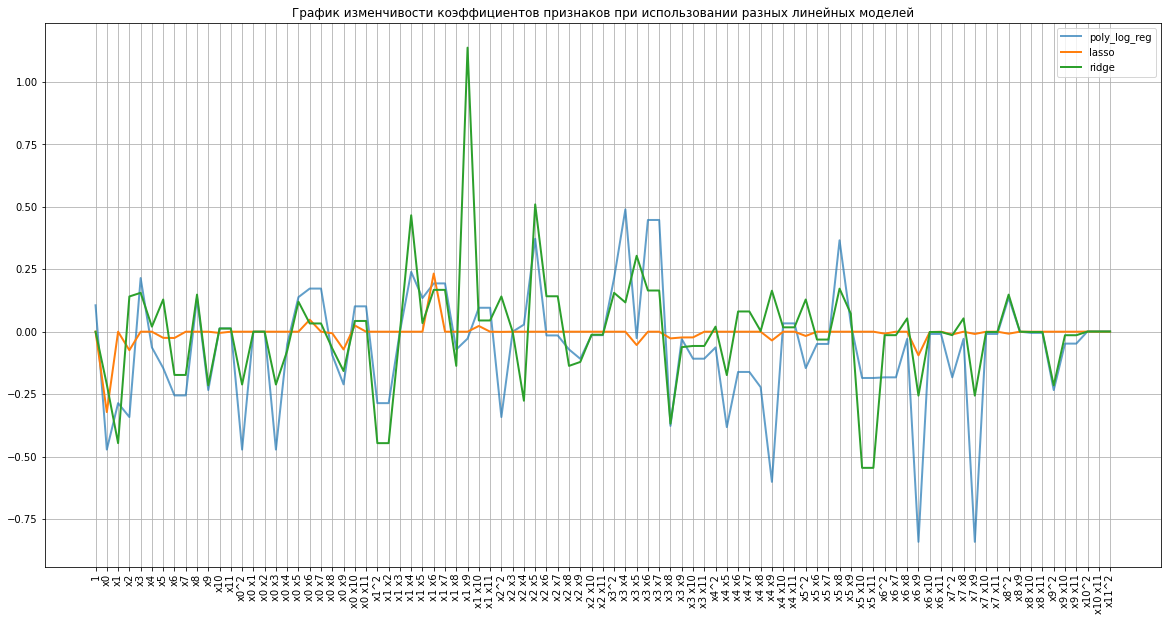

In [54]:
plt.figure(figsize=(20, 10))
plt.plot(poly.get_feature_names(), weights_log_reg_poly[0], alpha=0.7, label="poly_log_reg", lw=2, mec='b', mew=2, ms=10)
plt.plot(poly.get_feature_names(), weights_lasso, label="lasso", mec='r', lw=2, mew=2, ms=12)
plt.plot(poly.get_feature_names(), weights_ridge[0], label="ridge", mec='g', lw=2, mew=2, ms=14)
plt.legend()
plt.title("График изменчивости коэффициентов признаков при использовании разных линейных моделей")
plt.grid(True)
plt.tick_params(axis='x', rotation=90)

Итак, что мы видим: больше всего зануляются коэффициенты модели Lasso. Самые большие колебания видны у модели логистической регрессии, хотя она показала результат лучше, чем модель Ridge. При этом есть такие коэффициенты, которые в разных моделях имеют абсолютно разное значение. Так, например, признак "x3 * x5" в модели Ridge имеет коэффициент больше нуля ("гора"), а у моделей Lasso и логистической регрессии - наоборот отрицательное значение ("впадина"). А признак "x6 * x9" имеет очень большое отрицательное значение коэффициента в модели логистической регрессии, а у остальных - отрицательное, но довольно маленькое значение. При этом есть признак "х0 * х1", где все 3 модели зануляют коэффициент, т.е. по сути этот признак нам не нужен.

Идем к дополнительным заданиям: но сначала сделаем задание 5, а закончим заданием 4, т.к. там идет работа с тестовой выборкой.

***5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной***

Построим PCA и посмотрим, какие компоненты составляют наибольшую часть дисперсии целевой переменной. Для этого возьмем наш обучающий датасет:

In [55]:
df = pd.DataFrame(f_train_poly)
df.columns = poly.get_feature_names()
df = df.drop('1', axis=1)
df

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x8^2,x8 x9,x8 x10,x8 x11,x9^2,x9 x10,x9 x11,x10^2,x10 x11,x11^2
0,1.0,0.0,0.0,1.0,0.0,0.0,-0.058989,-0.058989,0.0,0.0,...,0.0,0.0,-0.0,-0.0,0.0,-0.000000,-0.000000,2.867187,2.867187,2.867187
1,0.0,0.0,1.0,0.0,0.0,0.0,-1.434934,-1.434934,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.142495,1.142495,1.305295,1.305295,1.305295
2,0.0,1.0,1.0,0.0,0.0,0.0,-1.434934,-1.434934,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.538898,1.538898,2.368208,2.368208,2.368208
3,0.0,1.0,1.0,0.0,0.0,0.0,-1.434934,-1.434934,0.0,1.0,...,0.0,0.0,-0.0,-0.0,1.0,-0.928688,-0.928688,0.862462,0.862462,0.862462
4,1.0,0.0,0.0,1.0,0.0,0.0,0.681904,0.681904,0.0,0.0,...,0.0,0.0,-0.0,-0.0,0.0,-0.000000,-0.000000,0.152682,0.152682,0.152682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15413,1.0,0.0,0.0,1.0,0.0,0.0,0.576062,0.576062,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.549700,1.549700,1.549700
15414,1.0,0.0,0.0,1.0,1.0,0.0,-0.164831,-0.164831,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.640930,1.640930,1.640930
15415,1.0,0.0,0.0,1.0,0.0,0.0,1.105271,1.105271,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,2.144147,2.144147,2.144147
15416,1.0,0.0,0.0,1.0,1.0,0.0,-0.905724,-0.905724,0.0,1.0,...,0.0,0.0,-0.0,-0.0,1.0,-1.133888,-1.133888,1.285702,1.285702,1.285702


In [56]:
pca = PCA(n_components = 1)   # задаем количество измерений, на которые будет производиться проекция
features_PCAreduced = pca.fit_transform(np.transpose(df))

In [57]:
pca_df = pd.DataFrame(features_PCAreduced)
pca_df.index = df.columns
pca_df[0].sort_values(ascending=False).head(10)

x7^2       200.358452
x6^2       200.358452
x6 x7      200.358452
x11^2       93.601785
x10^2       93.601785
x10 x11     93.601785
x3          40.355738
x3^2        40.355738
x0 x6       36.215668
x0 x7       36.215668
Name: 0, dtype: float64

In [58]:
pca_df[0].sort_values(ascending=False).tail(10)

x3 x11   -25.536493
x3 x10   -25.536493
x10      -29.283390
x11      -29.283390
x1 x6    -34.299637
x1 x7    -34.299637
x2 x6    -54.112730
x2 x7    -54.112730
x7 x9    -69.104600
x6 x9    -69.104600
Name: 0, dtype: float64

Мы видим, что есть часть признаков, которые составляют наибольшую часть дисперсии таргета: это переменные "x7^2", "x6^2",    
"x6 * x7", "x11^2", "x10^2", "x10 * x11", "x7 * x9*  и "x6 * x9". Построим гистограмму, чтобы было нагляднее:   

(-75.0, 205.0)

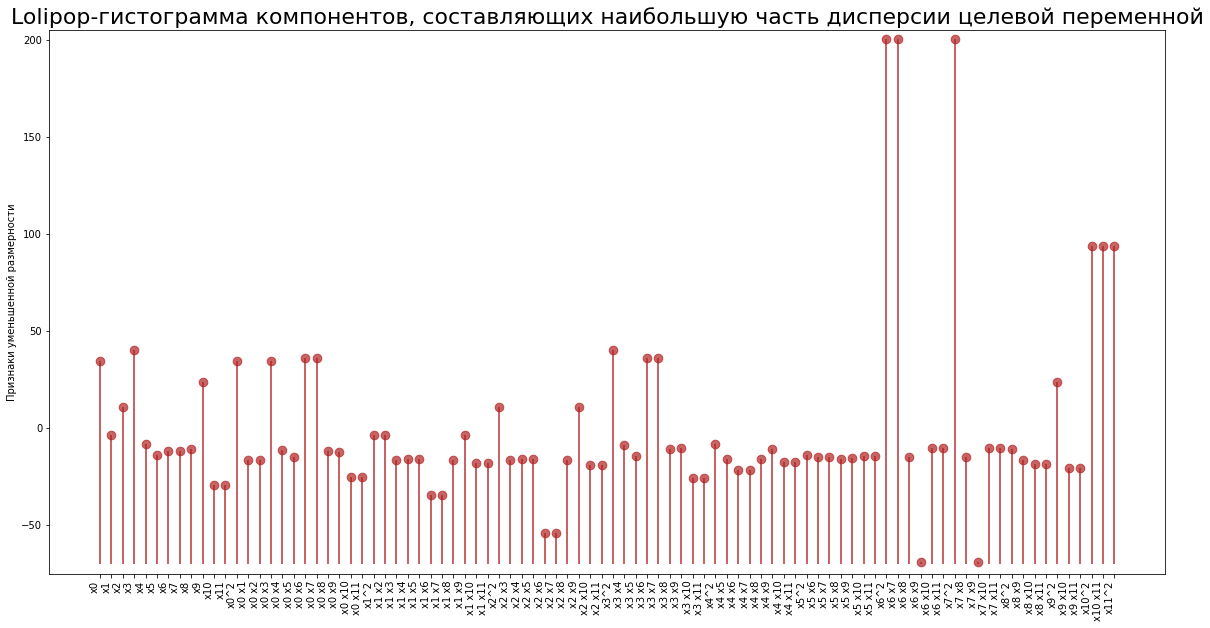

In [59]:
import matplotlib.patches as patches
# Гистограмма
fig, ax = plt.subplots(figsize=(20,10))
ax.vlines(x=pca_df.index, ymin=-70, ymax=pca_df[0], color='firebrick', alpha=0.7, linewidth=2)
ax.scatter(x=pca_df.index, y=pca_df[0], s=75, color='firebrick', alpha=0.7)
 
# Подписи данных
ax.set_title('Lolipop-гистограмма компонентов, составляющих наибольшую часть дисперсии целевой переменной', fontdict={'size':22})
ax.set_ylabel('Признаки уменьшенной размерности')
ax.set_xticks(pca_df.index)
ax.set_xticklabels(pca_df.index, rotation=90, fontdict={'horizontalalignment': 'right', 'size':10})
ax.set_ylim(-75, 205)

Теперь видно, что больше всего выделяются менно указанные нами выше признаки. Они в большинстве своем и составляют наибольшую часть дисперсии таргета.

И задание № ***4: Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC***

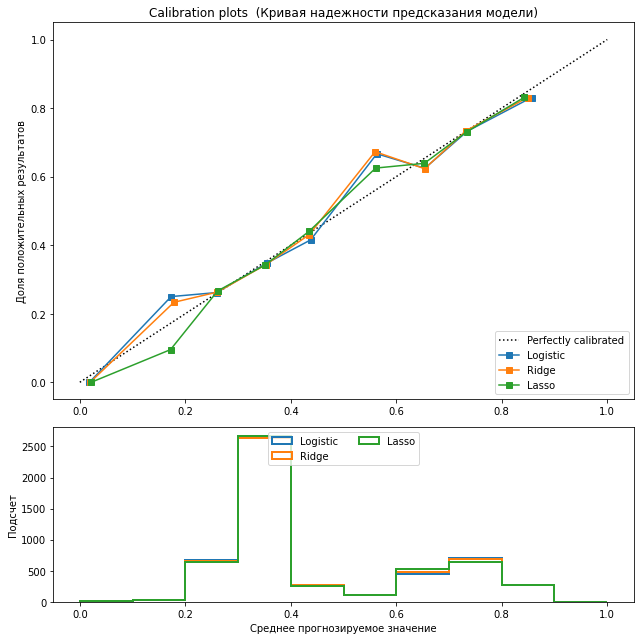

In [60]:
plt.figure(figsize=(9, 9))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(log_reg_poly, 'Logistic'),
                  (ridge, 'Ridge'),
                  (lasso, 'Lasso')]:
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(f_test_poly)[:, 1]
    else:  # если нет такого атрибута
        prob_pos = clf.decision_function(f_test_poly)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        prob_pos = clf.predict(f_test_poly)
    fraction_of_positives, mean_predicted_value = calibration_curve(target_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Доля положительных результатов")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (Кривая надежности предсказания модели)')

ax2.set_xlabel("Среднее прогнозируемое значение")
ax2.set_ylabel("Подсчет")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

Итак, по графикам довольно трудно сказать, какая модель лучше всего откалибрована.  
Поэтому перепроверим результат работы моделей на тестовой выборке:

*Метрика ROC-AUC на тесте.*   

Модель логистической регрессии:

In [61]:
print('ROC-AUC Score for Polynomial LogisticRegression: {}'.format(roc_auc_score(target_test, log_reg_poly.predict_proba(f_test_poly)[:, 1])))

ROC-AUC Score for Polynomial LogisticRegression: 0.6891850718983923


Модель с регуляризацией L1 - Lasso:

In [62]:
print('ROC-AUC Score for Polynomial Lasso: {}'.format(roc_auc_score(target_test, lasso.predict_proba(f_test_poly)[:, 1])))

ROC-AUC Score for Polynomial Lasso: 0.6894365971724699


Модель с регуляризацией L2 - Ridge:

In [63]:
print('ROC-AUC Score for Polynomial Ridge: {}'.format(roc_auc_score(target_test, ridge.predict_proba(f_test_poly)[:, 1])))

ROC-AUC Score for Polynomial Ridge: 0.689191811917917


На основании теста можно сделать вывод, что модель с регуляризацией L1 - Lasso показала наилучший результат.

#### Выводы

Таким образом, в ходе данной работы были проделаны следующие задания:
1. Проведен анализ данных, в результате которого были выявлены закономерности и аномалии, позволяющие ближе познакомиться с данными. В результате обучения (постфактум) выяснилось, что при удалении аномалий и выбросов модели обучаются хуже. Соответственно, из данных ничего не удалялось, кроме пропусков в таргете.     
2. Подготовлены фичи для обучения модели: с помощью полинома сгенерированы признаки, обработаны категориальные признаки (в частности из столбца с датой выведены новые столбцы с отдельными элементами даты - годом, месяцем, днем года, днем недели).  
3. Обучены модели: логистическая регрессия, Lasso, Ridge; построен график коэффициентов, где наглядно представлена информация о том, как меняется величина коэффициентов, а также какие из них в какой модели зануляются.  
4. Построен PCA на подготовленных признаках, выявлены компоненты, составляющие наибольшую часть дисперсии целевой переменной.  
5. Проведено сравнение результатов работы моделей на тестовом наборе данных. В результате сравнения выявлен победитель - модель Lasso показала результат выше, чем остальные модели.